<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/learning-evolution/sequences/P1C3_RealEvolution/P1C3_Sequence4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **1.3.4: Learning and Evolution**
In the last sequence we saw how the evolutionary process itself creates ever changing environments and consequently selective pressure for rapid adaptation. In the sequence before we saw how sex and recombination can drastically accelerate the evolutionary process, i.e. adaptation over generational time. In this sequence we turn to adaptation 'within lifetime'. Within lifetime adaptation is sometimes called phentoypic plasticity, with learned behaviour as a kind of pinnacle of phenotypic placitity. For long lived organisms with complex and flexible behaviours, ongoing adaptive plasticity learning is critically important.

### Objective: Appreciate the evolutionary advantage of within lifetime adaptation, both as a hedge against environmental variability and uncertainty, and as an accelerator of response to selection.

In this sequence we explore the following questions through simulations and mathematical analyses:

* How and under what conditions does within lifetime adaptation (learning) serve as a hedge against a changing environment?

* How and under what conditions does within lifetime adaptation (learning) increase the rate of response to changing selective pressures.

* Why do we expect more within lifetime learning in long-lived animals with behavioural flexibility?


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C3_S4"

Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 1.3.4.1: Learning as a Hedge Against Uncertainty

One argument for learning from an evolutionary perspective is that some aspects of the environment change rapidly and in inherently unpredictable ways. When the 'correct' phenotype or behaviour depends on these unpredictable aspects, determination of the mature phenotype through development and, analogously, behavior through learning should be more contingent on environmental context and less determined genetically. The following model and simulations will help to illustrate how within-lifetime adaptation e.g. learning can be selected over genetic determination when the environment changes rapidly and unpredictably enough and how full genetic determination is favoured in environments that change only very slowly.

We abstract our strike-no-strike game, interpreting the genetic loci as specifying the presence or absence of various neural connections, both inhibitory and excitatory. These connections could be thought of as existing between the receptors on the antennae and the muscles responsible for the striking behavior of our lurk-and-strike predator (the interpretation is inspired by Nolan and Hinton, 1987, from which much of this sequence is drawn), but they could also be thought of as specifying the layout of any neural circuit responsible for some set of environmentally contingent behaviours. We assume that there is some ideal 'target' neural configuration, specified by a target bitstring $y$ of length $n$ and so in the simplest case our fitness score function, $z$, for a genome $g$ (also of length $n$) is defined as  

$$z(g) := \sum_{i=1}^n I(y_i = g_i)$$.

Here $I(y_i = g_i)$ is an indicator function which takes the value one when $y_i = g_i$ (indicating a match), and zero when the condition is not met. Roughly, the interpretation here is that as the actual neural configuration approaches the ideal neural configuration the particular behaviour the neural circuit governs becomes better suited to the environment with the resulting impact on fitness score.

In this highly simplified model 'learning' is implemented as follows (still drawing from Hinton and Nolan 1987). Instead of our genome consisting exclusively of loci specifying the presence or absence of a given connection in the neural circuit, we consider two paired bitstrings $g$ and $f$. While the $g$ bits retain their original interpretation as specifying connections, the bits in $f$ (for 'flexibility') indicate that the corresponding connection is subject to within-lifetime determination through 'learning'. So the $g$ values at a given locus $g_i$ are only relevant to the fitness of the organism if $f_i=0$ and the connection is genetically determined, otherwise if $f_i=1$ the value of $g_i$ is basically irrelevant since the connection will be set by learning. (Note that this is a kind of epistasis where the impact of one gene is heavily mediated or modified by another.) Our simplified learning mechanism tries a random combination of settings on each learning trial. If the combination of the flexible and genetically specified parameters ever produces a payoff that is either better or worse than any previously experienced payoffs, connections are set and fixed at a value that produced the higher of the two experienced payoffs and this configuration is used for the remainder of the learning trials. If no change in payoffs is experienced trial and error learning continues. This implicitly assumes that the organism can "recognize" when it has achieved a relatively good or bad setting, and recall a previous 'good' setting. This recognition ability is required for effective learning. It's important to note that this model represents a highly simplified abstraction of neural adaptation, and that typical real-world neural learning is far more complex and nuanced. This model, while simplified, captures essential dynamics that help illustrate the interplay between evolution and learning, allowing us to focus on the high-level interaction between learning and evolution without the intricacies of more complex and realistic neural adaptation.

The total fitness score $F(g)$ for each individual will be the cumulative total payoff over all the learning trials and is given by

$$F(g,f) := \sum_{t=1}^T z(g'(t))$$

where $g'(t)$ is the test parameters used on each learning trial $t$ of $T$ total learning trials and is determined as

$$ g'_i(t) = \begin{cases}
g_i & \text{if } f_i = 0 \\
\text{Bernoulli}(0.5) & \text{if } f_i = 1 \text{ and } t \leq t^* \\
g^*_i & \text{if } f_i = 1 \text{ and } t > t^*
\end{cases}
$$

Here $t^*$ is the first learning trial where there is variance in the payoff and $g^*$ are the settings associated with a high experienced payoff. So, in this model, $g^*$ represents an optimal connection configuration discovered during the learning trials up and including trial $t^*$ which is then consistently applied in subsequent trials now learning has stopped. Note that $F(g,f)$ is inherently stochastic. Also, recall that different forms of selection, e.g. proportional (additive), truncation, proportional (multiplicative a.k.a. softmax), will translate the individuals' fitness scores into fitness in the sense of replication rates.

In the coding exercise below we will implement the target based scoring function, and the learning rule, specified by the two aspects of the genome $g$ and $f$. To explore this idea of learning being adaptive in variable environments we will also implement environmental change, operationalized by some proportion of the 'target' being subject to change over time. Specifically some fixed proportion of target bitstring $y$ will have a fixed per-bit probability of flipping. This approach gives us a controlled way to examine how different rates of environmental change impact the balance between genetic determination and learning. In previous sequences we saw how this kind of dynamic environment is sometimes emergent amongst co-evolving populations, but here for simplicity we assume change just happens at a given rate (exogenously) without explicitly modeling the underlying evolutionary (or celestial or geological) drivers of this change.

**Coding Exercise: Implement minimal trial and error learning.**

On each learning round $t$ each individual who has yet to experience variable payoffs tries a new neural parameter configuration distributed as $g'(t)$ above, and receives a resulting score $z(g'(t))$. Additionally each round some proportion of the target $y$ is subject to change with some fixed probability. Let's adapt our evolutionary simulation function from the previous sequences to implement this simple form of learning and environmental change:

In [2]:
################################################################################
# TODO for students: Complete the lines with ... that are wrapped in lines
# of # ~~~~ to implement this learning rule within our evoluationary simulation.
# Note that sometimes elipses '...' are used when indexing numpy arrays,
# these elipsis are not meant to be changed or edited as part of the exercise
# Also, note that the simulation function is long and complex. Often when
# programming the primary challenge is not writing the code, but finding where
# the code needs a very small change. This exercise aims at developing this
# ability.
raise NotImplementedError("Exercise: implement simple learning rule")
################################################################################


def evo_learning_simulation(
  pop_size=1000, n_gen=200, num_blocks=20, block_size=1,
  has_changing_environment=True, change_env_prop = 0.5, env_change_rate=0.0,
  has_learning=True, n_learning_trials=100,
  mutation_rate=0.025, has_mutation=True,
  has_recombination=True, has_assortative_pairing=True, recombination_type='crossover',
  selection_type='softmax', #softmax, deterministic truncation, proportional truncation
  softmax_temp=1, truncation_threshold=0.5,
  proportion_shift=0.0, proportion_scale=1.0,
  seed=None, init_pop='simple',
  compute_IQR=False):
  """
  Simulates the evolutionary process in a population of genotypes. This function
  models the evolution of genotypes through various mechanisms like learning,
  selection, mutation, recombination, and environmental changes. It is intended
  to explore how populations adapt to dynamic environments.

  Args:
    pop_size (int): Size of the population.
    n_gen (int): Number of generations to simulate.
    num_blocks (int): Number of receptors/genetic traits in each individual.
    has_changing_environment (bool): If True, the environment changes over generations.
    change_env_prop (float): Proportion of the environment that is subject to change.
    env_change_rate (float): Rate at which the environment changes.
    has_learning (bool): If True, individuals can learn during their lifetime.
    n_learning_trials (int): Number of learning trials per individual.
    mutation_rate (float): Rate of mutation in the population.
    has_mutation (bool): If True, mutations occur in the population.
    has_recombination (bool): If True, recombination occurs during reproduction.
    has_assortative_pairing (bool): If True, assortative mating is used in recombination.
    selection_type (str): Type of selection mechanism used.
    softmax_temp (float): Temperature parameter for softmax selection.
    truncation_threshold (float): Threshold for truncation selection.
    proportion_shift (float): Shift parameter for proportional selection.
    proportion_scale (float): Scale parameter for proportional selection.
    seed (int): Seed for random number generator.
    init_pop (str): Type of initial population ('simple' or 'adapted').
    compute_IQR (bool): If True, compute the interquartile range of the population scores

  Returns:
    dict: A dictionary containing historical data of various statistics over generations.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  if not has_learning:
    # with only one trial there is no learning
    n_learning_trials = 1

  # intialize the target connection pattern and how it changes each generation
  base_genome_shape = (num_blocks, block_size)
  if has_changing_environment:
    env_target = rng.integers(0, 2, size=base_genome_shape, dtype=np.bool_)
    num_elements = np.prod(base_genome_shape)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)
    num_changes = int(change_env_prop * num_elements)
    change_indices_1d = rng.choice(num_elements, size=num_changes, replace=False)
    change_indices = np.unravel_index(change_indices_1d, base_genome_shape)
    env_change_mask[change_indices] = True
  else:
    env_target = np.ones(base_genome_shape, dtype=np.bool_)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)

  genome_shape = (pop_size,) + base_genome_shape + (2,)
  # the two in the last dim is for preset and flexible

  # intialize the population genotypes
  if init_pop == 'simple':
    g_presets = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
    g_flexible = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
  elif init_pop == 'adapted':
    # For an adapted population, presets match the current environment
    reps = [pop_size] + [1] * len(env_target.shape)
    g_presets = np.tile(env_target, reps)  # Replicate env_target for each individual
    g_flexible = np.zeros(genome_shape[:-1], dtype=np.bool_)
  population_genome = np.stack((g_presets, g_flexible), axis=len(genome_shape)-1) # pop_size x receptors x x block_size x 2

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers, and even number of parents
    if not (
        np.isclose(num_parents, np.round(num_parents)) and
        np.isclose(offspring_per_parent, np.round(offspring_per_parent)) and
        num_parents % 2 == 0):
      print(truncation_threshold)
      print(pop_size)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, num_parents must be an even integer and divisor of pop_size, and offspring_per_parent must be an integer")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotypes and scores over generations.
  # Note, depending on simulation type not all of these will be
  # updated and returned
  mean_good_bits_hist = np.zeros(n_gen)
  mean_score_hist = np.zeros(n_gen)
  mean_flexible_change_hist = np.zeros(n_gen)
  mean_flexible_no_change_hist = np.zeros(n_gen)
  var_score_hist = np.zeros(n_gen)
  skew_score_hist = np.zeros(n_gen)
  lower_score_quartile_hist = np.zeros(n_gen)
  upper_score_quartile_hist = np.zeros(n_gen)

  # Helper function calculate score of params against the environmental target
  def score_calc(params, target):
    # params has shape pop_size x num_blocks x block_size
    scores = np.sum(np.prod(np.array(params == target, dtype=float), axis=2), axis=1)
    return scores

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    g_presets = population_genome[..., 0]
    g_flexible = population_genome[..., 1]
    is_fixed = np.zeros(pop_size, dtype=np.bool_)
    if has_learning:
      best_scores = np.zeros(pop_size)
      cumulative_scores = np.zeros(pop_size)
      best_params = np.copy(g_presets)  # Initially, best parameters are the presets
      composite_params = np.copy(g_presets)  # Initially, composite parameters are the presets
      for t in range(n_learning_trials):
        # Explore only for individuals still learning
        still_learning = ~is_fixed
        expanded_shape = (pop_size,) + (1,) * (g_flexible.ndim - 1)
        still_learning_expanded = still_learning.reshape(expanded_shape)
        # This line is part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # update flexible params where learning is still happening
        to_update = np.logical_and(...)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Generate new samples only for the part of composite_params to be updated
        update_param_samples = rng.integers(0, 2, size=to_update.sum(), dtype=np.bool_)
        # This line is part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        composite_params[to_update] = ...
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # trial scores are computed for everyhone
        trial_scores = score_calc(composite_params, env_target)
        # but only learners should improve of decline
        improved = trial_scores > best_scores
        declined = trial_scores < best_scores
        best_scores[improved] = trial_scores[improved]
        best_params[improved] = composite_params[improved]  # Update best parameters
        # These lines are part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~
        # our learning rule is stop after any improvement
        is_fixed[improved] = ...
        # or if things get worse stop exploring and use the known best
        is_fixed[declined] = ...
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        composite_params[declined] = best_params[declined]
        cumulative_scores += trial_scores
      scores = cumulative_scores / n_learning_trials
    else:
      scores = score_calc(g_presets, env_target)

    # Track statistics of genotype scores over generations.
    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0

    flexible_env_and_g = g_flexible[:, env_change_mask]
    if any(dim == 0 for dim in flexible_env_and_g.shape):
      mean_flexible_change_ = 0
    else:
      mean_flexible_change_ = np.mean(np.mean(flexible_env_and_g, axis=1))

    fixed_env_flex_g = g_flexible[:, ~env_change_mask]
    if any(dim == 0 for dim in fixed_env_flex_g.shape):
      mean_flexible_no_change_ = 0
    else:
      mean_flexible_no_change_ = np.mean(np.mean(fixed_env_flex_g, axis=1))

    mean_good_bits_ = np.mean(np.sum(g_presets == env_target, axis=1))
    mean_score_hist[generation] = mean_
    var_score_hist[generation] = var_
    skew_score_hist[generation] = skew_
    lower_score_quartile_hist[generation] = np.percentile(scores, 25)
    upper_score_quartile_hist[generation] = np.percentile(scores, 75)
    mean_flexible_change_hist[generation] = mean_flexible_change_
    mean_flexible_no_change_hist[generation] = mean_flexible_no_change_
    mean_good_bits_hist[generation] = mean_good_bits_

    # Selective Reproduction of different types
    if has_recombination and has_assortative_pairing:
      # Shuffle and then sort the population by scores
      shuffled_indices = np.arange(pop_size)
      rng.shuffle(shuffled_indices)
      population_genome = population_genome[shuffled_indices]
      scores = scores[shuffled_indices]
      # Sort the population by scores
      sorted_indices = np.argsort(scores)[::-1]  # Higher scores are better
      population_genome = population_genome[sorted_indices]
      scores = scores[sorted_indices]

    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      scale_shift_scores = (pos_scores * proportion_scale) + proportion_shift
      if np.sum(scores) > 0:
        prob_scores = scale_shift_scores / np.sum(scale_shift_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp)
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, take only the top
      # num_parents individuals
      selected_indices = sorted(eligible_indices, key=lambda x: scores[x], reverse=True)[:num_parents]
      # split these into parent groups
      parent_set_1 = selected_indices[::2]
      parent_set_2 = selected_indices[1::2]
      # Replicate each parent in their respective sets
      parent_set_1 = np.repeat(parent_set_1, offspring_per_parent)
      parent_set_2 = np.repeat(parent_set_2, offspring_per_parent)
      # Shuffle the parent sets based on mating strategy
      if not has_assortative_pairing:
        rng.shuffle(parent_set_2)
      # Combine the two parent sets to form genome pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)
      parent_pairs[:, 0, ...] = population_genome[parent_set_1]
      parent_pairs[:, 1, ...] = population_genome[parent_set_2]
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")

    if selection_type != 'deterministic truncation':
      # form parent pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)

      if has_recombination:
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        pair_directions = rng.integers(0, 2, size=pop_size // 2) * 2 - 1  # Results in either -1 or 1
        if has_assortative_pairing:
          # Use pair direction for assortative mating
          selected_parent_indices_2 = selected_parent_indices_1 + pair_directions
        else:
          # For non-assortative mating, select a second set of parents
          selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                                 p=prob_scores, replace=True)
          # Correct self-pairing
          selected_parent_indices_2 = np.where( #ternary use of where
            selected_parent_indices_1 == selected_parent_indices_2, # if this condition
            (selected_parent_indices_2 + pair_directions) % pop_size, # do this
            selected_parent_indices_2) # other wise do this
        # Adjust any out-of-bounds indices
        selected_parent_indices_2[selected_parent_indices_2 < 0] = 1
        selected_parent_indices_2[selected_parent_indices_2 >= pop_size] = pop_size - 1
      else: # no recombination
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
      # use the selected indices to form the parent genome pairs
      parent_pairs[:, 0, ...] = population_genome[selected_parent_indices_1]
      parent_pairs[:, 1, ...] = population_genome[selected_parent_indices_2]

    # recombination
    if has_recombination:
      if recombination_type == 'random':
        mask_shape = (pop_size // 2,) + env_target.shape + (2,)
        mask1 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        mask2 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        children = np.empty_like(parent_pairs)
        children[:, 0, ...] = np.where(mask1, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
        children[:, 1, ...] = np.where(mask2, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
      elif recombination_type == 'crossover':
        # Flatten the genomes for crossover operations
        # Shape before flattening: (pop_size // 2, 2, num_blocks, block_size, 2)
        flat_parent_pairs = parent_pairs.reshape((pop_size // 2, 2, -1))
        # Shape after flattening: (pop_size // 2, 2, num_blocks * block_size * 2)
        # Generate two sets of unique crossover points for each parent pair
        crossover_points_1 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        crossover_points_2 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        # Create a range array that matches the last dimension of flat_parent_pairs
        # to help make the mask for crossover operations
        range_array = np.arange(flat_parent_pairs.shape[-1])
        # Use broadcasting to create masks: True if index is less than the crossover point
        mask1 = range_array < crossover_points_1[:, np.newaxis]
        mask2 = range_array < crossover_points_2[:, np.newaxis]
        mask2 = ~mask2
        children_flat = np.empty_like(flat_parent_pairs)
        children_flat[:, 0, :] = np.where(mask1, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children_flat[:, 1, :] = np.where(mask2, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children = children_flat.reshape(parent_pairs.shape)
      else:
        raise ValueError("Invalid recombination_type string, use one of random or crossover")
      recombined_population_genome = children.reshape(genome_shape)
      population_genome = recombined_population_genome
    else:
      # the population is just the selected parents
      population_genome = parent_pairs.reshape(genome_shape)

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population_genome.shape) < mutation_rate
      population_genome ^= mutation_mask

    # dynamic environment
    if has_changing_environment:
      # see which aspect of the environment change and update them
      did_change = env_change_mask & (rng.random(size = env_change_mask.shape) < env_change_rate)
      # flip the bits where change happened
      env_target[did_change] = ~env_target[did_change]

    # repeat the loop for n_gen iterations

  results = {
    'mean_score_hist': mean_score_hist,
    'var_score_hist': var_score_hist,
    'skew_score_hist': skew_score_hist,
    'mean_good_bits_hist': mean_good_bits_hist
  }
  if compute_IQR:
    results['lower_score_quartile_hist'] = lower_score_quartile_hist
    results['upper_score_quartile_hist'] = upper_score_quartile_hist,
  if has_changing_environment:
    results['mean_flexible_change_hist'] = mean_flexible_change_hist
    results['mean_flexible_no_change_hist'] = mean_flexible_no_change_hist
  return results

# Define a range of environmental change rates
env_change_rates =[0.0, 0.01, 0.1, 0.5]

# Initialize dictionaries to store the full histories
score_histories = {rate: [] for rate in env_change_rates}
flexible_change_histories = {rate: [] for rate in env_change_rates}
flexible_no_change_histories = {rate: [] for rate in env_change_rates}

# Run simulations for each change rate
for rate in env_change_rates:
  simulation_results = evo_learning_simulation(
      env_change_rate=rate,
    )
  # Store the full histories
  score_histories[rate] = simulation_results['mean_score_hist']
  flexible_change_histories[rate] = simulation_results['mean_flexible_change_hist']
  flexible_no_change_histories[rate] = simulation_results['mean_flexible_no_change_hist']

# Plotting using the object-oriented approach
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot Mean Score Histories
for rate, history in score_histories.items():
    axs[0].plot(history, label=f'Change Rate {rate:.2f}')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Mean Score')
axs[0].set_title('Mean Score Over Generations')
axs[0].legend()

# Plot Mean Flexibility for Change Eligible Histories
for rate, history in flexible_change_histories.items():
    axs[1].plot(history, label=f'Change Rate {rate:.2f}')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Mean Flexibility (Change Eligible)')
axs[1].set_title('Mean Flexibility (Change Eligible) Over Generations')
axs[1].legend()

# Plot Mean Flexibility for No Change Eligible Histories
for rate, history in flexible_no_change_histories.items():
    axs[2].plot(history, label=f'Change Rate {rate:.2f}')
axs[2].set_xlabel('Generation')
axs[2].set_ylabel('Mean Flexibility (No Change Eligible)')
axs[2].set_title('Mean Flexibility (No Change Eligible) Over Generations')
axs[2].legend()

remove_ip_clutter(fig)
plt.tight_layout()
plt.show()

NotImplementedError: ignored

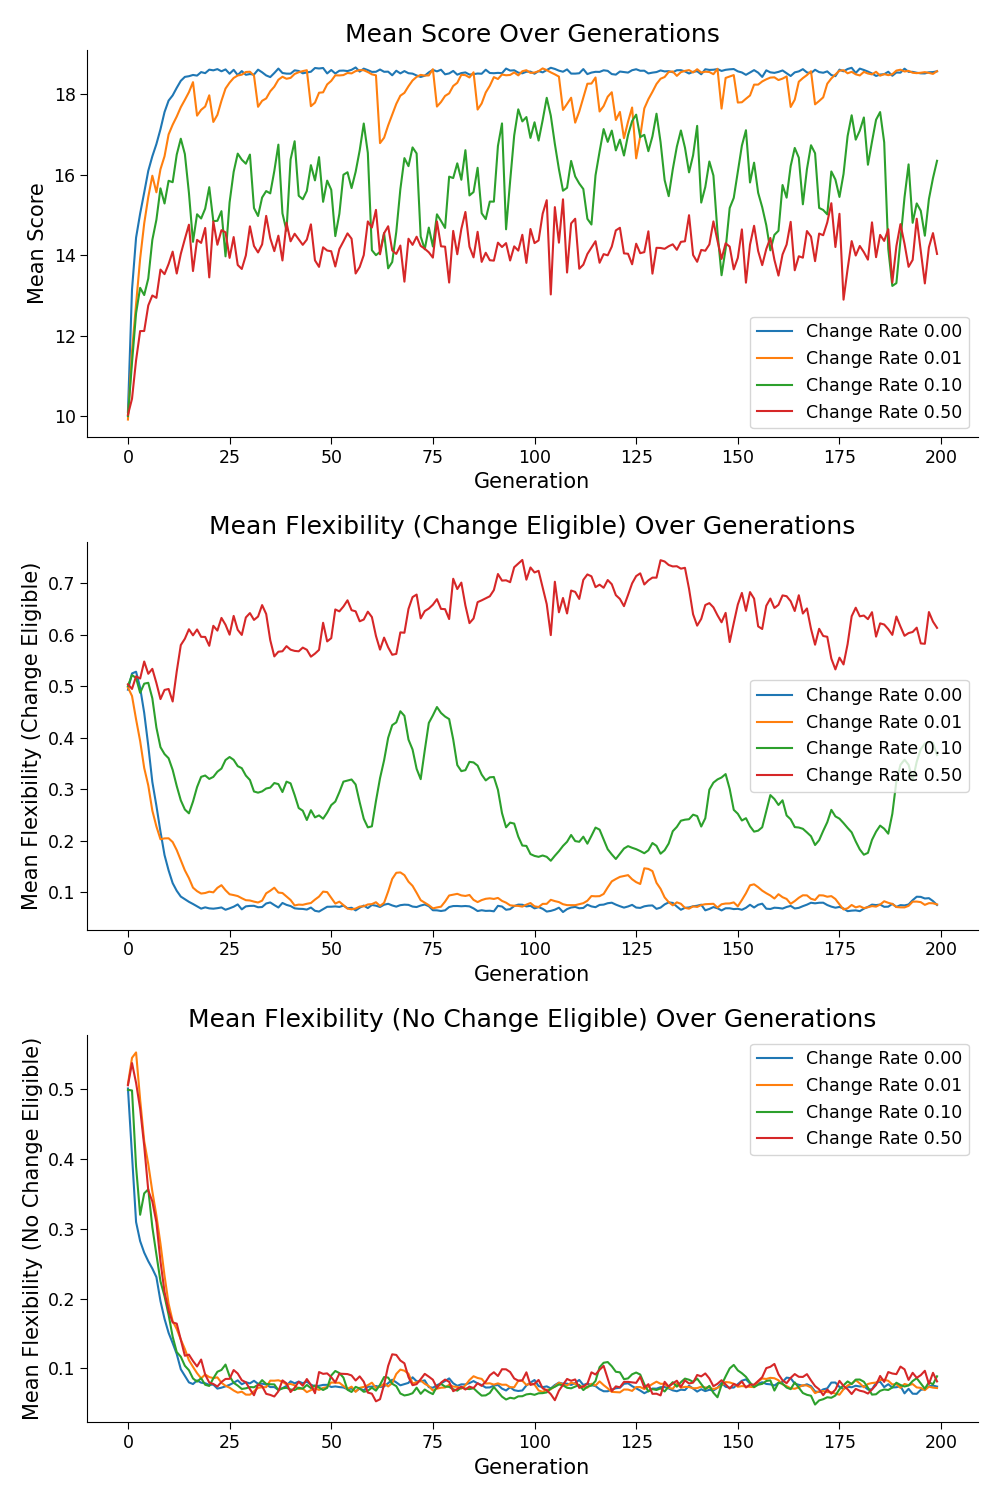

In [3]:
# to_remove solution


def evo_learning_simulation(
  pop_size=1000, n_gen=200, num_blocks=20, block_size=1,
  has_changing_environment=True, change_env_prop = 0.5, env_change_rate=0.0,
  has_learning=True, n_learning_trials=100,
  mutation_rate=0.025, has_mutation=True,
  has_recombination=True, has_assortative_pairing=True, recombination_type='crossover',
  selection_type='softmax', #softmax, deterministic truncation, proportional truncation
  softmax_temp=1, truncation_threshold=0.5,
  proportion_shift=0.0, proportion_scale=1.0,
  seed=None, init_pop='simple',
  compute_IQR=False):
  """
  Simulates the evolutionary process in a population of genotypes. This function
  models the evolution of genotypes through various mechanisms like learning,
  selection, mutation, recombination, and environmental changes. It is intended
  to explore how populations adapt to dynamic environments.

  Args:
    pop_size (int): Size of the population.
    n_gen (int): Number of generations to simulate.
    num_blocks (int): Number of receptors/genetic traits in each individual.
    has_changing_environment (bool): If True, the environment changes over generations.
    change_env_prop (float): Proportion of the environment that is subject to change.
    env_change_rate (float): Rate at which the environment changes.
    has_learning (bool): If True, individuals can learn during their lifetime.
    n_learning_trials (int): Number of learning trials per individual.
    mutation_rate (float): Rate of mutation in the population.
    has_mutation (bool): If True, mutations occur in the population.
    has_recombination (bool): If True, recombination occurs during reproduction.
    has_assortative_pairing (bool): If True, assortative mating is used in recombination.
    selection_type (str): Type of selection mechanism used.
    softmax_temp (float): Temperature parameter for softmax selection.
    truncation_threshold (float): Threshold for truncation selection.
    proportion_shift (float): Shift parameter for proportional selection.
    proportion_scale (float): Scale parameter for proportional selection.
    seed (int): Seed for random number generator.
    init_pop (str): Type of initial population ('simple' or 'adapted').
    compute_IQR (bool): If True, compute the interquartile range of the population scores

  Returns:
    dict: A dictionary containing historical data of various statistics over generations.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  if not has_learning:
    # with only one trial there is no learning
    n_learning_trials = 1

  # intialize the target connection pattern and how it changes each generation
  base_genome_shape = (num_blocks, block_size)
  if has_changing_environment:
    env_target = rng.integers(0, 2, size=base_genome_shape, dtype=np.bool_)
    num_elements = np.prod(base_genome_shape)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)
    num_changes = int(change_env_prop * num_elements)
    change_indices_1d = rng.choice(num_elements, size=num_changes, replace=False)
    change_indices = np.unravel_index(change_indices_1d, base_genome_shape)
    env_change_mask[change_indices] = True
  else:
    env_target = np.ones(base_genome_shape, dtype=np.bool_)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)

  genome_shape = (pop_size,) + base_genome_shape + (2,)
  # the two in the last dim is for preset and flexible

  # intialize the population genotypes
  if init_pop == 'simple':
    g_presets = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
    g_flexible = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
  elif init_pop == 'adapted':
    # For an adapted population, presets match the current environment
    reps = [pop_size] + [1] * len(env_target.shape)
    g_presets = np.tile(env_target, reps)  # Replicate env_target for each individual
    g_flexible = np.zeros(genome_shape[:-1], dtype=np.bool_)
  population_genome = np.stack((g_presets, g_flexible), axis=len(genome_shape)-1) # pop_size x receptors x x block_size x 2

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers, and even number of parents
    if not (
        np.isclose(num_parents, np.round(num_parents)) and
        np.isclose(offspring_per_parent, np.round(offspring_per_parent)) and
        num_parents % 2 == 0):
      print(truncation_threshold)
      print(pop_size)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, num_parents must be an even integer and divisor of pop_size, and offspring_per_parent must be an integer")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotypes and scores over generations.
  # Note, depending on simulation type not all of these will be
  # updated and returned
  mean_good_bits_hist = np.zeros(n_gen)
  mean_score_hist = np.zeros(n_gen)
  mean_flexible_change_hist = np.zeros(n_gen)
  mean_flexible_no_change_hist = np.zeros(n_gen)
  var_score_hist = np.zeros(n_gen)
  skew_score_hist = np.zeros(n_gen)
  lower_score_quartile_hist = np.zeros(n_gen)
  upper_score_quartile_hist = np.zeros(n_gen)

  # Helper function calculate score of params against the environmental target
  def score_calc(params, target):
    # params has shape pop_size x num_blocks x block_size
    scores = np.sum(np.prod(np.array(params == target, dtype=float), axis=2), axis=1)
    return scores

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    g_presets = population_genome[..., 0]
    g_flexible = population_genome[..., 1]
    is_fixed = np.zeros(pop_size, dtype=np.bool_)
    if has_learning:
      best_scores = np.zeros(pop_size)
      cumulative_scores = np.zeros(pop_size)
      best_params = np.copy(g_presets)  # Initially, best parameters are the presets
      composite_params = np.copy(g_presets)  # Initially, composite parameters are the presets
      for t in range(n_learning_trials):
        # Explore only for individuals still learning
        still_learning = ~is_fixed
        expanded_shape = (pop_size,) + (1,) * (g_flexible.ndim - 1)
        still_learning_expanded = still_learning.reshape(expanded_shape)
        # This line is part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # update flexible params where learning is still happening
        to_update = np.logical_and(still_learning_expanded, g_flexible)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Generate new samples only for the part of composite_params to be updated
        update_param_samples = rng.integers(0, 2, size=to_update.sum(), dtype=np.bool_)
        # This line is part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        composite_params[to_update] = update_param_samples
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # trial scores are computed for everyhone
        trial_scores = score_calc(composite_params, env_target)
        # but only learners should improve of decline
        improved = trial_scores > best_scores
        declined = trial_scores < best_scores
        best_scores[improved] = trial_scores[improved]
        best_params[improved] = composite_params[improved]  # Update best parameters
        # These lines are part of the coding exercise ~~~~~~~~~~~~~~~~~~~~~~~~~
        # our learning rule is stop after any improvement
        is_fixed[improved] = True
        # or if things get worse stop exploring and use the known best
        is_fixed[declined] = True
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        composite_params[declined] = best_params[declined]
        cumulative_scores += trial_scores
      scores = cumulative_scores / n_learning_trials
    else:
      scores = score_calc(g_presets, env_target)

    # Track statistics of genotype scores over generations.
    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0

    flexible_env_and_g = g_flexible[:, env_change_mask]
    if any(dim == 0 for dim in flexible_env_and_g.shape):
      mean_flexible_change_ = 0
    else:
      mean_flexible_change_ = np.mean(np.mean(flexible_env_and_g, axis=1))

    fixed_env_flex_g = g_flexible[:, ~env_change_mask]
    if any(dim == 0 for dim in fixed_env_flex_g.shape):
      mean_flexible_no_change_ = 0
    else:
      mean_flexible_no_change_ = np.mean(np.mean(fixed_env_flex_g, axis=1))

    mean_good_bits_ = np.mean(np.sum(g_presets == env_target, axis=1))
    mean_score_hist[generation] = mean_
    var_score_hist[generation] = var_
    skew_score_hist[generation] = skew_
    lower_score_quartile_hist[generation] = np.percentile(scores, 25)
    upper_score_quartile_hist[generation] = np.percentile(scores, 75)
    mean_flexible_change_hist[generation] = mean_flexible_change_
    mean_flexible_no_change_hist[generation] = mean_flexible_no_change_
    mean_good_bits_hist[generation] = mean_good_bits_

    # Selective Reproduction of different types
    if has_recombination and has_assortative_pairing:
      # Shuffle and then sort the population by scores
      shuffled_indices = np.arange(pop_size)
      rng.shuffle(shuffled_indices)
      population_genome = population_genome[shuffled_indices]
      scores = scores[shuffled_indices]
      # Sort the population by scores
      sorted_indices = np.argsort(scores)[::-1]  # Higher scores are better
      population_genome = population_genome[sorted_indices]
      scores = scores[sorted_indices]

    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      scale_shift_scores = (pos_scores * proportion_scale) + proportion_shift
      if np.sum(scores) > 0:
        prob_scores = scale_shift_scores / np.sum(scale_shift_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp)
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, take only the top
      # num_parents individuals
      selected_indices = sorted(eligible_indices, key=lambda x: scores[x], reverse=True)[:num_parents]
      # split these into parent groups
      parent_set_1 = selected_indices[::2]
      parent_set_2 = selected_indices[1::2]
      # Replicate each parent in their respective sets
      parent_set_1 = np.repeat(parent_set_1, offspring_per_parent)
      parent_set_2 = np.repeat(parent_set_2, offspring_per_parent)
      # Shuffle the parent sets based on mating strategy
      if not has_assortative_pairing:
        rng.shuffle(parent_set_2)
      # Combine the two parent sets to form genome pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)
      parent_pairs[:, 0, ...] = population_genome[parent_set_1]
      parent_pairs[:, 1, ...] = population_genome[parent_set_2]
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")

    if selection_type != 'deterministic truncation':
      # form parent pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)

      if has_recombination:
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        pair_directions = rng.integers(0, 2, size=pop_size // 2) * 2 - 1  # Results in either -1 or 1
        if has_assortative_pairing:
          # Use pair direction for assortative mating
          selected_parent_indices_2 = selected_parent_indices_1 + pair_directions
        else:
          # For non-assortative mating, select a second set of parents
          selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                                 p=prob_scores, replace=True)
          # Correct self-pairing
          selected_parent_indices_2 = np.where( #ternary use of where
            selected_parent_indices_1 == selected_parent_indices_2, # if this condition
            (selected_parent_indices_2 + pair_directions) % pop_size, # do this
            selected_parent_indices_2) # other wise do this
        # Adjust any out-of-bounds indices
        selected_parent_indices_2[selected_parent_indices_2 < 0] = 1
        selected_parent_indices_2[selected_parent_indices_2 >= pop_size] = pop_size - 1
      else: # no recombination
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
      # use the selected indices to form the parent genome pairs
      parent_pairs[:, 0, ...] = population_genome[selected_parent_indices_1]
      parent_pairs[:, 1, ...] = population_genome[selected_parent_indices_2]

    # recombination
    if has_recombination:
      if recombination_type == 'random':
        mask_shape = (pop_size // 2,) + env_target.shape + (2,)
        mask1 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        mask2 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        children = np.empty_like(parent_pairs)
        children[:, 0, ...] = np.where(mask1, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
        children[:, 1, ...] = np.where(mask2, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
      elif recombination_type == 'crossover':
        # Flatten the genomes for crossover operations
        # Shape before flattening: (pop_size // 2, 2, num_blocks, block_size, 2)
        flat_parent_pairs = parent_pairs.reshape((pop_size // 2, 2, -1))
        # Shape after flattening: (pop_size // 2, 2, num_blocks * block_size * 2)
        # Generate two sets of unique crossover points for each parent pair
        crossover_points_1 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        crossover_points_2 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        # Create a range array that matches the last dimension of flat_parent_pairs
        # to help make the mask for crossover operations
        range_array = np.arange(flat_parent_pairs.shape[-1])
        # Use broadcasting to create masks: True if index is less than the crossover point
        mask1 = range_array < crossover_points_1[:, np.newaxis]
        mask2 = range_array < crossover_points_2[:, np.newaxis]
        mask2 = ~mask2
        children_flat = np.empty_like(flat_parent_pairs)
        children_flat[:, 0, :] = np.where(mask1, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children_flat[:, 1, :] = np.where(mask2, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children = children_flat.reshape(parent_pairs.shape)
      else:
        raise ValueError("Invalid recombination_type string, use one of random or crossover")
      recombined_population_genome = children.reshape(genome_shape)
      population_genome = recombined_population_genome
    else:
      # the population is just the selected parents
      population_genome = parent_pairs.reshape(genome_shape)

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population_genome.shape) < mutation_rate
      population_genome ^= mutation_mask

    # dynamic environment
    if has_changing_environment:
      # see which aspect of the environment change and update them
      did_change = env_change_mask & (rng.random(size = env_change_mask.shape) < env_change_rate)
      # flip the bits where change happened
      env_target[did_change] = ~env_target[did_change]

    # repeat the loop for n_gen iterations

  results = {
    'mean_score_hist': mean_score_hist,
    'var_score_hist': var_score_hist,
    'skew_score_hist': skew_score_hist,
    'mean_good_bits_hist': mean_good_bits_hist
  }
  if compute_IQR:
    results['lower_score_quartile_hist'] = lower_score_quartile_hist
    results['upper_score_quartile_hist'] = upper_score_quartile_hist,
  if has_changing_environment:
    results['mean_flexible_change_hist'] = mean_flexible_change_hist
    results['mean_flexible_no_change_hist'] = mean_flexible_no_change_hist
  return results

# Define a range of environmental change rates
env_change_rates =[0.0, 0.01, 0.1, 0.5]

# Initialize dictionaries to store the full histories
score_histories = {rate: [] for rate in env_change_rates}
flexible_change_histories = {rate: [] for rate in env_change_rates}
flexible_no_change_histories = {rate: [] for rate in env_change_rates}

# Run simulations for each change rate
for rate in env_change_rates:
  simulation_results = evo_learning_simulation(
      env_change_rate=rate,
    )
  # Store the full histories
  score_histories[rate] = simulation_results['mean_score_hist']
  flexible_change_histories[rate] = simulation_results['mean_flexible_change_hist']
  flexible_no_change_histories[rate] = simulation_results['mean_flexible_no_change_hist']

# Plotting using the object-oriented approach
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot Mean Score Histories
for rate, history in score_histories.items():
    axs[0].plot(history, label=f'Change Rate {rate:.2f}')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Mean Score')
axs[0].set_title('Mean Score Over Generations')
axs[0].legend()

# Plot Mean Flexibility for Change Eligible Histories
for rate, history in flexible_change_histories.items():
    axs[1].plot(history, label=f'Change Rate {rate:.2f}')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Mean Flexibility (Change Eligible)')
axs[1].set_title('Mean Flexibility (Change Eligible) Over Generations')
axs[1].legend()

# Plot Mean Flexibility for No Change Eligible Histories
for rate, history in flexible_no_change_histories.items():
    axs[2].plot(history, label=f'Change Rate {rate:.2f}')
axs[2].set_xlabel('Generation')
axs[2].set_ylabel('Mean Flexibility (No Change Eligible)')
axs[2].set_title('Mean Flexibility (No Change Eligible) Over Generations')
axs[2].legend()

remove_ip_clutter(fig)
plt.tight_layout()
plt.show()

The simulation results above help illustrate how the adaptive balance between learning (plasticity) and genetic determination shifts in response to environmental variability.

In the first plot "Mean Score Over Generations", we see a clear trend: stable environments lead to higher and more rapidly stabilizing mean scores (blue line, change rate = 0.00, orange line, change rate = 0.01). As the environment's change rate increases (red and green lines), mean scores become more erratic and generally lower. This aligns with the expectation that optimization through evolution will always lag behind in dynamic environments where the 'ideal phenotype' can change from generation to generation.

The second plot, "Mean Flexibility (Change Eligible) Over Generations", tracks the evolution of the mean proportion of learning-determined loci, for those loci associated with fluctuating environmental targets (there are 10 such loci in these particular simulations). The plot shows a higher mean flexibility at loci where environmental targets change frequently (green, 0.1, and red, 0.5, lines) compared to loci with slow or no change (orange, 0.01, and blue, 0.0, lines respectively). This suggests that learning is advantageous and selected for when environmental unpredictability is high, as it gives organisms a way to rapidly adjust to new conditions within their lifetime and thus reduces dependence on genetic changes over generational time to cope with environmental dynamics (so called adaptive tracking). When the environmental volatility is very high (red, 0.5) there is basically no evolutionary tracking of the variable environment, and learning/plasticity dominates. In contrast, at an intermediate level of volatility (green, 0.1) we see that a combination of adaptive tracking and plasticity is stable within the population.

The "Mean Flexibility (No Change Eligible) Over Generations" plot serves as a sanity check, confirming that where environmental targets don't change, learning is selected against. When there is no environmental variability full genetic determination is selected for.

The overarching message from these simulations is clear: genetic determination is beneficial in static environments where the optimal phenotype is constant. In such cases the 'correct phenotype' can in some sense be known fully by the genome and so should simply be developed as rapidly as possible. In such cases learning and other forms of phenotypic plasticity that might slow development have no adaptive value. Conversely, in volatile environments, learning and plasticity can be selected for. Note that in these simulations all of the many mechanisms required for effective plasticity have been abstracted away, e.g. the details of how flexible development/neural plasticity, evaluation of different outcomes, sensing the environment, etc. is achieved is left completely unanswered and so these simulations serve only to hint at the kinds of scenarios when such mechanism could be evolutionarily favoured, without giving any consideration to the costs associated with developing and maintaining such mechanisms.

In [4]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 1.3.4.2: Some Fitness Score Functions are Hard for Evolution to Optimize

In the previous section we saw how evolutionary processes are responsive to (but not anticipatory of) environmental change, and how as a result, in a changing environment the population phenotype will often lag behind the optimal phenotype for a given environment. We also saw how within lifetime learning could be an adaptive response to dealing with environmental change and uncertainty. In the previous simulations the connection between a genetic change and the fitness increment was quite direct given the structure of the fitness score function (the sum of 'correct' alleles) and so as a result selection was able to (relatively) rapidly steer the population towards good phenotypes for the given environment. This is not always the case.

Genes rarely operate in isolation. They are typically part of dynamic networks, engaging in a molecular dialogue to orchestrate complex patterns of gene expression. These networks shape the diverse phenotypes (traits) we observe, from physical characteristics to behavioural patterns. Pleiotropy, where a single gene influences multiple traits, and epistasis, where the effect of one gene is significantly shaped by others, are the norm rather than the exception. Consequently, most traits are polygenic, emerging from the collective influence of multiple genes. Note that in our models we rarely consider these complications, and for the illustrative goals of most of our models we do not need to. However, if and when the goal of modeling becomes quantitative prediction actual empirical gene frequencies, these details, in particular when they can and cannot be ignored in modeling, do become critical.

For a moment now though we *are* going to consider how a very simplified form of epistasis can result in a fitness score function that is much more difficult for an evolutionary process to optimize.

We will continue to use the 'strike-no-strike' decision problem but with some added complexity. We still consider an organism with $n$ chemosensory receptors, each corresponding to $n$ possible food/non-food chemical markers in the environment. However, now the functionality of these receptors is determined by $nk$ distinct genetic switches, represented as a bit-string $g$ of length $nk$ with every block of $k$ contiguous bits determines the efficacy of the receptor in the strike-no-strike game. Instead of thinking of each genetic bit as corresponding to the expression or absence of a receptor for a particular marker, we instead think of each genetic bit as determining some connections in a neural circuit between receptors and muscles and only a very particular set of connections allows for the effective use of the receptor. In our learning simulations above we had a kind of epistasis where the the impact of the $g$ (preset) type loci was dependent on the the $f$ (flexibility) type loci. Here we have an even stronger form of epistasis where the fitness impact of any one $g$ type loci is fully dependent on the other genes that share its receptor block.

In  the previous model having the 'correct' allele, i.e. $g_i = y_i$, at any loci, conferred a small, independent, additive benefit to fitness score. Now having the correct allele at a given loci, only provides a fitness score benefit if the other $k-1$ loci in that 'receptor block' on the genome also happen to be correct, otherwise the independent effect of that loci is neutral.

Making the same rough interpretation as before when a given block of connections aligns with the target neural circuit configuration the particular behaviour the neural circuit governs becomes better suited to the environment with the resulting impact on fitness score. This gives us our single trial fitness score as

$$ z(g):= \sum_{i=0}^{n-1} \prod_{j=1}^{k} I(y_{j+ik} = g_{j+ik}) $$

**Coding Exercise: Implement the new fitness score function.**

Each individual in the population has a genotype $g$, and a resulting score per trial $\sum_{i=0}^{n-1} \prod_{j=1}^{k} I(y_{j+ik} = g_{j+ik})$ i.e. the number of blocks of entirely 'good bits'. We will leave learning and environmental change out of our simulation in this first instance. Here $g$ is the genetic specification of the neural circuit $y$ is the target and $I$ is an indicator function. Let's adapt our evolutionary simulation function from before to use this new fitness score function.

In [5]:
################################################################################
# TODO for students: Complete the score_calc function definition to implement
# this new per-trial score function. Hints, 1) think hard about the shapes of
# the composite_params and env_target arrays, 2) use numpy broadcasting to
# compare all composite_params to the target 3) use numpy sum and prod functions
# along specific axis, 4) play around with small test arrays in other (new)
# code cells before implementing your solution.
raise NotImplementedError("Exercise: implement complex score function")
################################################################################


def evo_learning_simulation(
  pop_size=1000, n_gen=200, num_blocks=20, block_size=1,
  has_changing_environment=True, change_env_prop = 0.5, env_change_rate=0.0,
  has_learning=True, n_learning_trials=100,
  mutation_rate=0.025, has_mutation=True,
  has_recombination=True, has_assortative_pairing=True, recombination_type='crossover',
  selection_type='softmax', #softmax, deterministic truncation, proportional truncation
  softmax_temp=1, truncation_threshold=0.5,
  proportion_shift=0.0, proportion_scale=1.0,
  seed=None, init_pop='simple',
  compute_IQR=False):
  """
  Simulates the evolutionary process in a population of genotypes. This function
  models the evolution of genotypes through various mechanisms like learning,
  selection, mutation, recombination, and environmental changes. It is intended
  to explore how populations adapt to dynamic environments.

  Args:
    pop_size (int): Size of the population.
    n_gen (int): Number of generations to simulate.
    num_blocks (int): Number of receptors/genetic traits in each individual.
    has_changing_environment (bool): If True, the environment changes over generations.
    change_env_prop (float): Proportion of the environment that is subject to change.
    env_change_rate (float): Rate at which the environment changes.
    has_learning (bool): If True, individuals can learn during their lifetime.
    n_learning_trials (int): Number of learning trials per individual.
    mutation_rate (float): Rate of mutation in the population.
    has_mutation (bool): If True, mutations occur in the population.
    has_recombination (bool): If True, recombination occurs during reproduction.
    has_assortative_pairing (bool): If True, assortative mating is used in recombination.
    selection_type (str): Type of selection mechanism used.
    softmax_temp (float): Temperature parameter for softmax selection.
    truncation_threshold (float): Threshold for truncation selection.
    proportion_shift (float): Shift parameter for proportional selection.
    proportion_scale (float): Scale parameter for proportional selection.
    seed (int): Seed for random number generator.
    init_pop (str): Type of initial population ('simple' or 'adapted').
    compute_IQR (bool): If True, compute the interquartile range of the population scores

  Returns:
    dict: A dictionary containing historical data of various statistics over generations.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  if not has_learning:
    # with only one trial there is no learning
    n_learning_trials = 1

  # intialize the target connection pattern and how it changes each generation
  base_genome_shape = (num_blocks, block_size)
  if has_changing_environment:
    env_target = rng.integers(0, 2, size=base_genome_shape, dtype=np.bool_)
    num_elements = np.prod(base_genome_shape)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)
    num_changes = int(change_env_prop * num_elements)
    change_indices_1d = rng.choice(num_elements, size=num_changes, replace=False)
    change_indices = np.unravel_index(change_indices_1d, base_genome_shape)
    env_change_mask[change_indices] = True
  else:
    env_target = np.ones(base_genome_shape, dtype=np.bool_)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)

  genome_shape = (pop_size,) + base_genome_shape + (2,)
  # the two in the last dim is for preset and flexible

  # intialize the population genotypes
  if init_pop == 'simple':
    g_presets = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
    g_flexible = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
  elif init_pop == 'adapted':
    # For an adapted population, presets match the current environment
    reps = [pop_size] + [1] * len(env_target.shape)
    g_presets = np.tile(env_target, reps)  # Replicate env_target for each individual
    g_flexible = np.zeros(genome_shape[:-1], dtype=np.bool_)
  population_genome = np.stack((g_presets, g_flexible), axis=len(genome_shape)-1) # pop_size x receptors x x block_size x 2

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers, and even number of parents
    if not (
        np.isclose(num_parents, np.round(num_parents)) and
        np.isclose(offspring_per_parent, np.round(offspring_per_parent)) and
        num_parents % 2 == 0):
      print(truncation_threshold)
      print(pop_size)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, num_parents must be an even integer and divisor of pop_size, and offspring_per_parent must be an integer")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotypes and scores over generations.
  # Note, depending on simulation type not all of these will be
  # updated and returned
  mean_good_bits_hist = np.zeros(n_gen)
  mean_score_hist = np.zeros(n_gen)
  mean_flexible_change_hist = np.zeros(n_gen)
  mean_flexible_no_change_hist = np.zeros(n_gen)
  var_score_hist = np.zeros(n_gen)
  skew_score_hist = np.zeros(n_gen)
  lower_score_quartile_hist = np.zeros(n_gen)
  upper_score_quartile_hist = np.zeros(n_gen)

  # Helper function calculate score of params against the environmental target
  def score_calc(params, target):
    # params has shape pop_size x num_blocks x block_size
    scores = ...
    return scores

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    g_presets = population_genome[..., 0]
    g_flexible = population_genome[..., 1]
    is_fixed = np.zeros(pop_size, dtype=np.bool_)
    if has_learning:
      best_scores = np.zeros(pop_size)
      cumulative_scores = np.zeros(pop_size)
      best_params = np.copy(g_presets)  # Initially, best parameters are the presets
      composite_params = np.copy(g_presets)  # Initially, composite parameters are the presets
      for t in range(n_learning_trials):
        # Explore only for individuals still learning
        still_learning = ~is_fixed
        expanded_shape = (pop_size,) + (1,) * (g_flexible.ndim - 1)
        still_learning_expanded = still_learning.reshape(expanded_shape)
        to_update = np.logical_and(still_learning_expanded, g_flexible)
        # Generate new samples only for the part of composite_params to be updated
        update_param_samples = rng.integers(0, 2, size=to_update.sum(), dtype=np.bool_)
        composite_params[to_update] = update_param_samples
        # trial scores are computed for everyhone
        trial_scores = score_calc(composite_params, env_target)
        # but only learners should improve of decline
        improved = trial_scores > best_scores
        declined = trial_scores < best_scores
        best_scores[improved] = trial_scores[improved]
        best_params[improved] = composite_params[improved]  # Update best parameters
        # our learning rule is stop after any improvement
        is_fixed[improved] = True
        # or if things get worse stop exploring and use the known best
        is_fixed[declined] = True
        composite_params[declined] = best_params[declined]
        cumulative_scores += trial_scores
      scores = cumulative_scores / n_learning_trials
    else:
      scores = score_calc(g_presets, env_target)

    # Track statistics of genotype scores over generations.
    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0

    flexible_env_and_g = g_flexible[:, env_change_mask]
    if any(dim == 0 for dim in flexible_env_and_g.shape):
      mean_flexible_change_ = 0
    else:
      mean_flexible_change_ = np.mean(np.mean(flexible_env_and_g, axis=1))

    fixed_env_flex_g = g_flexible[:, ~env_change_mask]
    if any(dim == 0 for dim in fixed_env_flex_g.shape):
      mean_flexible_no_change_ = 0
    else:
      mean_flexible_no_change_ = np.mean(np.mean(fixed_env_flex_g, axis=1))

    mean_good_bits_ = np.mean(np.sum(g_presets == env_target, axis=1))
    mean_score_hist[generation] = mean_
    var_score_hist[generation] = var_
    skew_score_hist[generation] = skew_
    lower_score_quartile_hist[generation] = np.percentile(scores, 25)
    upper_score_quartile_hist[generation] = np.percentile(scores, 75)
    mean_flexible_change_hist[generation] = mean_flexible_change_
    mean_flexible_no_change_hist[generation] = mean_flexible_no_change_
    mean_good_bits_hist[generation] = mean_good_bits_

    # Selective Reproduction of different types
    if has_recombination and has_assortative_pairing:
      # Shuffle and then sort the population by scores
      shuffled_indices = np.arange(pop_size)
      rng.shuffle(shuffled_indices)
      population_genome = population_genome[shuffled_indices]
      scores = scores[shuffled_indices]
      # Sort the population by scores
      sorted_indices = np.argsort(scores)[::-1]  # Higher scores are better
      population_genome = population_genome[sorted_indices]
      scores = scores[sorted_indices]

    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      scale_shift_scores = (pos_scores * proportion_scale) + proportion_shift
      if np.sum(scores) > 0:
        prob_scores = scale_shift_scores / np.sum(scale_shift_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp)
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, take only the top
      # num_parents individuals
      selected_indices = sorted(eligible_indices, key=lambda x: scores[x], reverse=True)[:num_parents]
      # split these into parent groups
      parent_set_1 = selected_indices[::2]
      parent_set_2 = selected_indices[1::2]
      # Replicate each parent in their respective sets
      parent_set_1 = np.repeat(parent_set_1, offspring_per_parent)
      parent_set_2 = np.repeat(parent_set_2, offspring_per_parent)
      # Shuffle the parent sets based on mating strategy
      if not has_assortative_pairing:
        rng.shuffle(parent_set_2)
      # Combine the two parent sets to form genome pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)
      parent_pairs[:, 0, ...] = population_genome[parent_set_1]
      parent_pairs[:, 1, ...] = population_genome[parent_set_2]
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")

    if selection_type != 'deterministic truncation':
      # form parent pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)

      if has_recombination:
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        pair_directions = rng.integers(0, 2, size=pop_size // 2) * 2 - 1  # Results in either -1 or 1
        if has_assortative_pairing:
          # Use pair direction for assortative mating
          selected_parent_indices_2 = selected_parent_indices_1 + pair_directions
        else:
          # For non-assortative mating, select a second set of parents
          selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                                 p=prob_scores, replace=True)
          # Correct self-pairing
          selected_parent_indices_2 = np.where( #ternary use of where
            selected_parent_indices_1 == selected_parent_indices_2, # if this condition
            (selected_parent_indices_2 + pair_directions) % pop_size, # do this
            selected_parent_indices_2) # other wise do this
        # Adjust any out-of-bounds indices
        selected_parent_indices_2[selected_parent_indices_2 < 0] = 1
        selected_parent_indices_2[selected_parent_indices_2 >= pop_size] = pop_size - 1
      else: # no recombination
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
      # use the selected indices to form the parent genome pairs
      parent_pairs[:, 0, ...] = population_genome[selected_parent_indices_1]
      parent_pairs[:, 1, ...] = population_genome[selected_parent_indices_2]

    # recombination
    if has_recombination:
      if recombination_type == 'random':
        mask_shape = (pop_size // 2,) + env_target.shape + (2,)
        mask1 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        mask2 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        children = np.empty_like(parent_pairs)
        children[:, 0, ...] = np.where(mask1, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
        children[:, 1, ...] = np.where(mask2, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
      elif recombination_type == 'crossover':
        # Flatten the genomes for crossover operations
        # Shape before flattening: (pop_size // 2, 2, num_blocks, block_size, 2)
        flat_parent_pairs = parent_pairs.reshape((pop_size // 2, 2, -1))
        # Shape after flattening: (pop_size // 2, 2, num_blocks * block_size * 2)
        # Generate two sets of unique crossover points for each parent pair
        crossover_points_1 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        crossover_points_2 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        # Create a range array that matches the last dimension of flat_parent_pairs
        # to help make the mask for crossover operations
        range_array = np.arange(flat_parent_pairs.shape[-1])
        # Use broadcasting to create masks: True if index is less than the crossover point
        mask1 = range_array < crossover_points_1[:, np.newaxis]
        mask2 = range_array < crossover_points_2[:, np.newaxis]
        mask2 = ~mask2
        children_flat = np.empty_like(flat_parent_pairs)
        children_flat[:, 0, :] = np.where(mask1, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children_flat[:, 1, :] = np.where(mask2, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children = children_flat.reshape(parent_pairs.shape)
      else:
        raise ValueError("Invalid recombination_type string, use one of random or crossover")
      recombined_population_genome = children.reshape(genome_shape)
      population_genome = recombined_population_genome
    else:
      # the population is just the selected parents
      population_genome = parent_pairs.reshape(genome_shape)

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population_genome.shape) < mutation_rate
      population_genome ^= mutation_mask

    # dynamic environment
    if has_changing_environment:
      # see which aspect of the environment change and update them
      did_change = env_change_mask & (rng.random(size = env_change_mask.shape) < env_change_rate)
      # flip the bits where change happened
      env_target[did_change] = ~env_target[did_change]

    # repeat the loop for n_gen iterations

  results = {
    'mean_score_hist': mean_score_hist,
    'var_score_hist': var_score_hist,
    'skew_score_hist': skew_score_hist,
    'mean_good_bits_hist': mean_good_bits_hist
  }
  if compute_IQR:
    results['lower_score_quartile_hist'] = lower_score_quartile_hist
    results['upper_score_quartile_hist'] = upper_score_quartile_hist,
  if has_changing_environment:
    results['mean_flexible_change_hist'] = mean_flexible_change_hist
    results['mean_flexible_no_change_hist'] = mean_flexible_no_change_hist
  return results

# Parameters
common_params = {
    'n_gen': 200,
    'pop_size': 1000,
    'init_pop': 'simple',
    'seed': 123,
    'mutation_rate': 0.01,
    'has_mutation': True,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'recombination_type': 'crossover',
    'has_learning': False,
    'n_learning_trials': 1,
    'proportion_shift': 1.0,
    'proportion_scale': 19.0,
    'has_changing_environment':False,
    'change_env_prop': 0.0,
    'env_change_rate': 0.0,
    'compute_IQR': False,
}

# Create 3x1 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

selection_types = ['proportional', 'deterministic truncation', 'softmax']
base_colors = {'proportional': 'Blues', 'deterministic truncation': 'Reds', 'softmax': 'Greens'}
labels = {'proportional': 'Proportional', 'deterministic truncation': 'Deterministic Truncation', 'softmax': 'Softmax'}

# Define parameter dictionaries for each block size
#vary num_blocks with block_size to keep constant genotype length = num_blocks * block_size
block_sizes =       [ 2, 5, 10, 20]
numbers_of_blocks = [10, 4,  2,  1]
block_params = []
for block_size, num_blocks in zip(block_sizes, numbers_of_blocks):
  params = {'block_size': block_size, 'num_blocks': num_blocks}
  block_params.append(params)

# Plot for each selection type
for ax, selection_type in zip(axs, selection_types):
  base_color = base_colors[selection_type]
  base = matplotlib.colormaps[base_color]
  num_shades = len(block_sizes)
  colors = [base((i+2)/(num_shades+2)) for i in range(num_shades)]
  label = labels[selection_type]

  for block_param, color in zip(block_params, colors):
    # Combine parameters
    combined_params = {**common_params,
                       **block_param,
                       'selection_type': selection_type}
    r = evo_learning_simulation(**combined_params)
    generations = np.arange(combined_params['n_gen'])

    # normalized mean score and quartiles
    mean_hist = r['mean_score_hist']/combined_params['num_blocks']
    ax.plot(generations, mean_hist, color=color, label=label + " - Block Size: {block_param['block_size']}, Block Number: {block_param['num_blocks']}")
  norm = matplotlib.colors.Normalize(vmin=min(block_sizes), vmax=max(block_sizes))
  scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=base)

  ax.set_title(f'Selection Type: {selection_type}')
  ax.set_xlabel('Generation')
  ax.set_ylabel('Normalized Mean Score')
  #ax.legend()
  cbar = fig.colorbar(scalar_mappable, ax=ax, orientation='vertical')
  cbar.set_label('Bits per Block')

plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

NotImplementedError: ignored

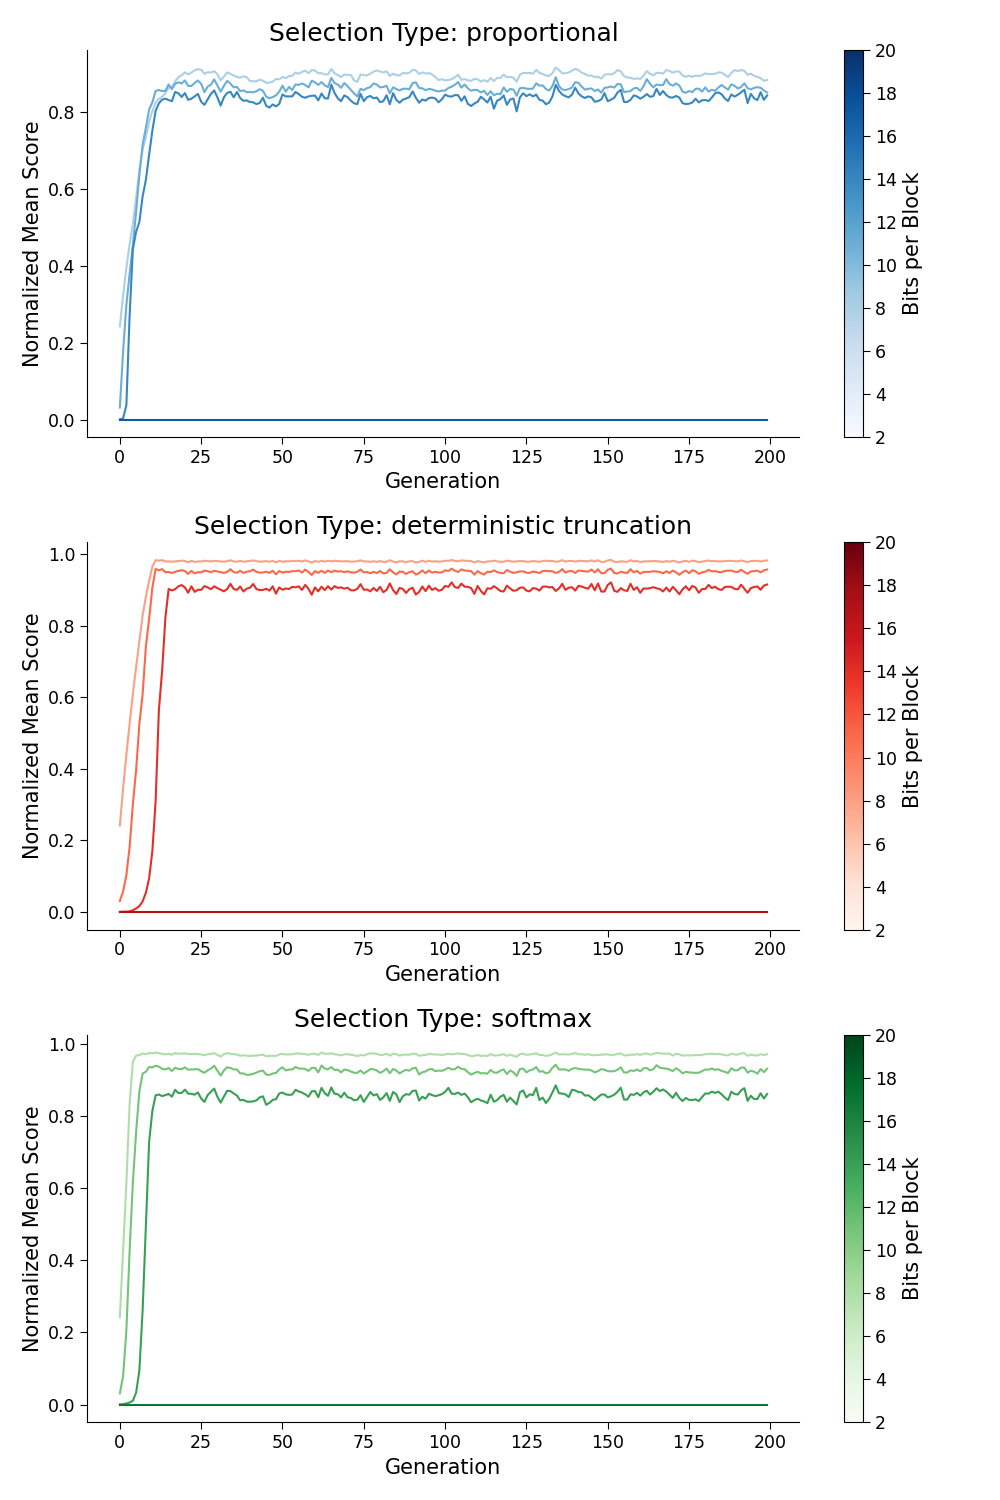

In [6]:
# to _remove solution


def evo_learning_simulation(
  pop_size=1000, n_gen=200, num_blocks=20, block_size=1,
  has_changing_environment=True, change_env_prop = 0.5, env_change_rate=0.0,
  has_learning=True, n_learning_trials=100,
  mutation_rate=0.025, has_mutation=True,
  has_recombination=True, has_assortative_pairing=True, recombination_type='crossover',
  selection_type='softmax', #softmax, deterministic truncation, proportional truncation
  softmax_temp=1, truncation_threshold=0.5,
  proportion_shift=0.0, proportion_scale=1.0,
  seed=None, init_pop='simple',
  compute_IQR=False):
  """
  Simulates the evolutionary process in a population of genotypes. This function
  models the evolution of genotypes through various mechanisms like learning,
  selection, mutation, recombination, and environmental changes. It is intended
  to explore how populations adapt to dynamic environments.

  Args:
    pop_size (int): Size of the population.
    n_gen (int): Number of generations to simulate.
    num_blocks (int): Number of receptors/genetic traits in each individual.
    has_changing_environment (bool): If True, the environment changes over generations.
    change_env_prop (float): Proportion of the environment that is subject to change.
    env_change_rate (float): Rate at which the environment changes.
    has_learning (bool): If True, individuals can learn during their lifetime.
    n_learning_trials (int): Number of learning trials per individual.
    mutation_rate (float): Rate of mutation in the population.
    has_mutation (bool): If True, mutations occur in the population.
    has_recombination (bool): If True, recombination occurs during reproduction.
    has_assortative_pairing (bool): If True, assortative mating is used in recombination.
    selection_type (str): Type of selection mechanism used.
    softmax_temp (float): Temperature parameter for softmax selection.
    truncation_threshold (float): Threshold for truncation selection.
    proportion_shift (float): Shift parameter for proportional selection.
    proportion_scale (float): Scale parameter for proportional selection.
    seed (int): Seed for random number generator.
    init_pop (str): Type of initial population ('simple' or 'adapted').
    compute_IQR (bool): If True, compute the interquartile range of the population scores

  Returns:
    dict: A dictionary containing historical data of various statistics over generations.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  if not has_learning:
    # with only one trial there is no learning
    n_learning_trials = 1

  # intialize the target connection pattern and how it changes each generation
  base_genome_shape = (num_blocks, block_size)
  if has_changing_environment:
    env_target = rng.integers(0, 2, size=base_genome_shape, dtype=np.bool_)
    num_elements = np.prod(base_genome_shape)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)
    num_changes = int(change_env_prop * num_elements)
    change_indices_1d = rng.choice(num_elements, size=num_changes, replace=False)
    change_indices = np.unravel_index(change_indices_1d, base_genome_shape)
    env_change_mask[change_indices] = True
  else:
    env_target = np.ones(base_genome_shape, dtype=np.bool_)
    env_change_mask = np.zeros(base_genome_shape, dtype=np.bool_)

  genome_shape = (pop_size,) + base_genome_shape + (2,)
  # the two in the last dim is for preset and flexible

  # intialize the population genotypes
  if init_pop == 'simple':
    g_presets = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
    g_flexible = rng.integers(0, 2, size=genome_shape[:-1], dtype=np.bool_)
  elif init_pop == 'adapted':
    # For an adapted population, presets match the current environment
    reps = [pop_size] + [1] * len(env_target.shape)
    g_presets = np.tile(env_target, reps)  # Replicate env_target for each individual
    g_flexible = np.zeros(genome_shape[:-1], dtype=np.bool_)
  population_genome = np.stack((g_presets, g_flexible), axis=len(genome_shape)-1) # pop_size x receptors x x block_size x 2

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers, and even number of parents
    if not (
        np.isclose(num_parents, np.round(num_parents)) and
        np.isclose(offspring_per_parent, np.round(offspring_per_parent)) and
        num_parents % 2 == 0):
      print(truncation_threshold)
      print(pop_size)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, num_parents must be an even integer and divisor of pop_size, and offspring_per_parent must be an integer")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotypes and scores over generations.
  # Note, depending on simulation type not all of these will be
  # updated and returned
  mean_good_bits_hist = np.zeros(n_gen)
  mean_score_hist = np.zeros(n_gen)
  mean_flexible_change_hist = np.zeros(n_gen)
  mean_flexible_no_change_hist = np.zeros(n_gen)
  var_score_hist = np.zeros(n_gen)
  skew_score_hist = np.zeros(n_gen)
  lower_score_quartile_hist = np.zeros(n_gen)
  upper_score_quartile_hist = np.zeros(n_gen)

  # Helper function calculate score of params against the environmental target
  def score_calc(params, target):
    # params has shape pop_size x num_blocks x block_size
    scores = np.sum(np.prod(np.array(params == target, dtype=float), axis=2), axis=1)
    return scores

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    g_presets = population_genome[..., 0]
    g_flexible = population_genome[..., 1]
    is_fixed = np.zeros(pop_size, dtype=np.bool_)
    if has_learning:
      best_scores = np.zeros(pop_size)
      cumulative_scores = np.zeros(pop_size)
      best_params = np.copy(g_presets)  # Initially, best parameters are the presets
      composite_params = np.copy(g_presets)  # Initially, composite parameters are the presets
      for t in range(n_learning_trials):
        # Explore only for individuals still learning
        still_learning = ~is_fixed
        expanded_shape = (pop_size,) + (1,) * (g_flexible.ndim - 1)
        still_learning_expanded = still_learning.reshape(expanded_shape)
        to_update = np.logical_and(still_learning_expanded, g_flexible)
        # Generate new samples only for the part of composite_params to be updated
        update_param_samples = rng.integers(0, 2, size=to_update.sum(), dtype=np.bool_)
        composite_params[to_update] = update_param_samples
        # trial scores are computed for everyhone
        trial_scores = score_calc(composite_params, env_target)
        # but only learners should improve of decline
        improved = trial_scores > best_scores
        declined = trial_scores < best_scores
        best_scores[improved] = trial_scores[improved]
        best_params[improved] = composite_params[improved]  # Update best parameters
        # our learning rule is stop after any improvement
        is_fixed[improved] = True
        # or if things get worse stop exploring and use the known best
        is_fixed[declined] = True
        composite_params[declined] = best_params[declined]
        cumulative_scores += trial_scores
      scores = cumulative_scores / n_learning_trials
    else:
      scores = score_calc(g_presets, env_target)

    # Track statistics of genotype scores over generations.
    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0

    flexible_env_and_g = g_flexible[:, env_change_mask]
    if any(dim == 0 for dim in flexible_env_and_g.shape):
      mean_flexible_change_ = 0
    else:
      mean_flexible_change_ = np.mean(np.mean(flexible_env_and_g, axis=1))

    fixed_env_flex_g = g_flexible[:, ~env_change_mask]
    if any(dim == 0 for dim in fixed_env_flex_g.shape):
      mean_flexible_no_change_ = 0
    else:
      mean_flexible_no_change_ = np.mean(np.mean(fixed_env_flex_g, axis=1))

    mean_good_bits_ = np.mean(np.sum(g_presets == env_target, axis=1))
    mean_score_hist[generation] = mean_
    var_score_hist[generation] = var_
    skew_score_hist[generation] = skew_
    lower_score_quartile_hist[generation] = np.percentile(scores, 25)
    upper_score_quartile_hist[generation] = np.percentile(scores, 75)
    mean_flexible_change_hist[generation] = mean_flexible_change_
    mean_flexible_no_change_hist[generation] = mean_flexible_no_change_
    mean_good_bits_hist[generation] = mean_good_bits_

    # Selective Reproduction of different types
    if has_recombination and has_assortative_pairing:
      # Shuffle and then sort the population by scores
      shuffled_indices = np.arange(pop_size)
      rng.shuffle(shuffled_indices)
      population_genome = population_genome[shuffled_indices]
      scores = scores[shuffled_indices]
      # Sort the population by scores
      sorted_indices = np.argsort(scores)[::-1]  # Higher scores are better
      population_genome = population_genome[sorted_indices]
      scores = scores[sorted_indices]

    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      scale_shift_scores = (pos_scores * proportion_scale) + proportion_shift
      if np.sum(scores) > 0:
        prob_scores = scale_shift_scores / np.sum(scale_shift_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp)
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, take only the top
      # num_parents individuals
      selected_indices = sorted(eligible_indices, key=lambda x: scores[x], reverse=True)[:num_parents]
      # split these into parent groups
      parent_set_1 = selected_indices[::2]
      parent_set_2 = selected_indices[1::2]
      # Replicate each parent in their respective sets
      parent_set_1 = np.repeat(parent_set_1, offspring_per_parent)
      parent_set_2 = np.repeat(parent_set_2, offspring_per_parent)
      # Shuffle the parent sets based on mating strategy
      if not has_assortative_pairing:
        rng.shuffle(parent_set_2)
      # Combine the two parent sets to form genome pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)
      parent_pairs[:, 0, ...] = population_genome[parent_set_1]
      parent_pairs[:, 1, ...] = population_genome[parent_set_2]
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")

    if selection_type != 'deterministic truncation':
      # form parent pairs
      parent_pairs_shape = (pop_size // 2, 2,) + env_target.shape + (2,)
      parent_pairs = np.zeros(parent_pairs_shape, dtype=np.bool_)

      if has_recombination:
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        pair_directions = rng.integers(0, 2, size=pop_size // 2) * 2 - 1  # Results in either -1 or 1
        if has_assortative_pairing:
          # Use pair direction for assortative mating
          selected_parent_indices_2 = selected_parent_indices_1 + pair_directions
        else:
          # For non-assortative mating, select a second set of parents
          selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                                 p=prob_scores, replace=True)
          # Correct self-pairing
          selected_parent_indices_2 = np.where( #ternary use of where
            selected_parent_indices_1 == selected_parent_indices_2, # if this condition
            (selected_parent_indices_2 + pair_directions) % pop_size, # do this
            selected_parent_indices_2) # other wise do this
        # Adjust any out-of-bounds indices
        selected_parent_indices_2[selected_parent_indices_2 < 0] = 1
        selected_parent_indices_2[selected_parent_indices_2 >= pop_size] = pop_size - 1
      else: # no recombination
        selected_parent_indices_1 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
        selected_parent_indices_2 = rng.choice(pop_size, size=pop_size // 2,
                                               p=prob_scores, replace=True)
      # use the selected indices to form the parent genome pairs
      parent_pairs[:, 0, ...] = population_genome[selected_parent_indices_1]
      parent_pairs[:, 1, ...] = population_genome[selected_parent_indices_2]

    # recombination
    if has_recombination:
      if recombination_type == 'random':
        mask_shape = (pop_size // 2,) + env_target.shape + (2,)
        mask1 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        mask2 = rng.integers(0, 2, size=mask_shape).astype(np.bool_)
        children = np.empty_like(parent_pairs)
        children[:, 0, ...] = np.where(mask1, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
        children[:, 1, ...] = np.where(mask2, parent_pairs[:, 0, ...], parent_pairs[:, 1, ...])
      elif recombination_type == 'crossover':
        # Flatten the genomes for crossover operations
        # Shape before flattening: (pop_size // 2, 2, num_blocks, block_size, 2)
        flat_parent_pairs = parent_pairs.reshape((pop_size // 2, 2, -1))
        # Shape after flattening: (pop_size // 2, 2, num_blocks * block_size * 2)
        # Generate two sets of unique crossover points for each parent pair
        crossover_points_1 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        crossover_points_2 = rng.integers(1, flat_parent_pairs.shape[-1], size=(pop_size // 2,))
        # Create a range array that matches the last dimension of flat_parent_pairs
        # to help make the mask for crossover operations
        range_array = np.arange(flat_parent_pairs.shape[-1])
        # Use broadcasting to create masks: True if index is less than the crossover point
        mask1 = range_array < crossover_points_1[:, np.newaxis]
        mask2 = range_array < crossover_points_2[:, np.newaxis]
        mask2 = ~mask2
        children_flat = np.empty_like(flat_parent_pairs)
        children_flat[:, 0, :] = np.where(mask1, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children_flat[:, 1, :] = np.where(mask2, flat_parent_pairs[:, 0, :], flat_parent_pairs[:, 1, :])
        children = children_flat.reshape(parent_pairs.shape)
      else:
        raise ValueError("Invalid recombination_type string, use one of random or crossover")
      recombined_population_genome = children.reshape(genome_shape)
      population_genome = recombined_population_genome
    else:
      # the population is just the selected parents
      population_genome = parent_pairs.reshape(genome_shape)

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population_genome.shape) < mutation_rate
      population_genome ^= mutation_mask

    # dynamic environment
    if has_changing_environment:
      # see which aspect of the environment change and update them
      did_change = env_change_mask & (rng.random(size = env_change_mask.shape) < env_change_rate)
      # flip the bits where change happened
      env_target[did_change] = ~env_target[did_change]

    # repeat the loop for n_gen iterations

  results = {
    'mean_score_hist': mean_score_hist,
    'var_score_hist': var_score_hist,
    'skew_score_hist': skew_score_hist,
    'mean_good_bits_hist': mean_good_bits_hist
  }
  if compute_IQR:
    results['lower_score_quartile_hist'] = lower_score_quartile_hist
    results['upper_score_quartile_hist'] = upper_score_quartile_hist,
  if has_changing_environment:
    results['mean_flexible_change_hist'] = mean_flexible_change_hist
    results['mean_flexible_no_change_hist'] = mean_flexible_no_change_hist
  return results

# Parameters
common_params = {
    'n_gen': 200,
    'pop_size': 1000,
    'init_pop': 'simple',
    'seed': 123,
    'mutation_rate': 0.01,
    'has_mutation': True,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'recombination_type': 'crossover',
    'has_learning': False,
    'n_learning_trials': 1,
    'proportion_shift': 1.0,
    'proportion_scale': 19.0,
    'has_changing_environment':False,
    'change_env_prop': 0.0,
    'env_change_rate': 0.0,
    'compute_IQR': False,
}

# Create 3x1 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

selection_types = ['proportional', 'deterministic truncation', 'softmax']
base_colors = {'proportional': 'Blues', 'deterministic truncation': 'Reds', 'softmax': 'Greens'}
labels = {'proportional': 'Proportional', 'deterministic truncation': 'Deterministic Truncation', 'softmax': 'Softmax'}

# Define parameter dictionaries for each block size
#vary num_blocks with block_size to keep constant genotype length = num_blocks * block_size
block_sizes =       [ 2, 5, 10, 20]
numbers_of_blocks = [10, 4,  2,  1]
block_params = []
for block_size, num_blocks in zip(block_sizes, numbers_of_blocks):
  params = {'block_size': block_size, 'num_blocks': num_blocks}
  block_params.append(params)

# Plot for each selection type
for ax, selection_type in zip(axs, selection_types):
  base_color = base_colors[selection_type]
  base = matplotlib.colormaps[base_color]
  num_shades = len(block_sizes)
  colors = [base((i+2)/(num_shades+2)) for i in range(num_shades)]
  label = labels[selection_type]

  for block_param, color in zip(block_params, colors):
    # Combine parameters
    combined_params = {**common_params,
                       **block_param,
                       'selection_type': selection_type}
    r = evo_learning_simulation(**combined_params)
    generations = np.arange(combined_params['n_gen'])

    # normalized mean score and quartiles
    mean_hist = r['mean_score_hist']/combined_params['num_blocks']
    ax.plot(generations, mean_hist, color=color, label=label + " - Block Size: {block_param['block_size']}, Block Number: {block_param['num_blocks']}")
  norm = matplotlib.colors.Normalize(vmin=min(block_sizes), vmax=max(block_sizes))
  scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=base)

  ax.set_title(f'Selection Type: {selection_type}')
  ax.set_xlabel('Generation')
  ax.set_ylabel('Normalized Mean Score')
  #ax.legend()
  cbar = fig.colorbar(scalar_mappable, ax=ax, orientation='vertical')
  cbar.set_label('Bits per Block')

plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

In the simulations above we see the evolution of the (normalized) mean fitness score for different selection types, and different numbers of bits required to align before a fitness increment ([2, 5, 10, 20]). In each simulation there is mutation (but no recombination) to introduce new variance, yet the evolutionary process is unable to hit upon having all 20 bits in a receptor align at once (darkest lines) over 500 generations for any of these selection types. Fitness score functions like this, where a large co-adaption is required for any fitness increment, are sometimes referred to as 'needle-in-a-haystack' as there is one correct configuration, the needle, hidden among many, in this case roughly one million ($2^{20}$), incorrect configurations, the haystack. What makes this such a challenging problem for an evolutionary process is that all of the incorrect configurations look the same to selection; even though a configuration of one 'wrong' bit and nineteen 'right' bits is very close to the correct configuration in the genome space, from the perspective of selection, this close but wrong configuration is indistinguishable from any of the other wrong configurations. Selection gives no 'hot' or 'cold' style hints in this case to guide the evolutionary search. This is in stark contrast to the similar problem we looked at in the beginning of the sequence where selection was sensitive to every changing bit in the genome. For subsequent simulations we use 'proportional' selection, primarily for the sake of following Hinton and Nolan 1987.

Note though that even if the high scoring genotype is discovered through mutation and recombination, selection may not always be able to grow the frequency of this genotype within the population. Search and discovery with a so called 'flat' fitness landscape is just one aspect of the issue here. Additionally when using evolutionary search to find a large, tightly co-adapted configuration, recombination can be a liability. Consider that when this co-adaptation is discovered, if there is recombination then it is not easily passed on to descendants. When an adapted individual mates with any individual other than one almost identical to itself, the co-adaptation is likely to be destroyed by recombination. The crux of the issue is that for large co-adaptions very few, if any, improved genotypes are likely to appear in a given generation, and unless mating is strongly assortative these individuals are unlikely to mate with each other. For the co-adaptation to persist from generation to generation each good genotype must, on average, give rise to at least one good offspring in the next generation. If the dispersal of complex co-adaptations due to mating causes each good genotype to have less than one expected good offspring, the co-adaptation will not spread, even if it is discovered many times.


**Math Exercises:**

With some combination of large population size and many generation mutation alone (without recombination) will eventually hit upon this rare configuration. Assume a population of size $N$ where each individual has a single block of $n$ bits to be aligned

**Question 1.**
Calculate the approximate probability of an offspring with a 'good block' being born in a population where none of the previous generations have had a 'good block'. Use the following simplifying assumptions and hint:

> - Each bit in a randomly selected parent is equally likely to be a 1 or a 0. This will be close to true for large populations with some mutation and no selective pressure.
> - Mutation rate and genome size are such that 0.2 of the population has a single mutation in a given generation, and double mutations within an individual are rare enough to be ignored. (As is roughly the case in a genome of 20 bits with a per bit mutation rate of 0.01.)
> - Hint: Use the first order Taylor series approximation for $(1-p)^x$, around $p=0$.

**Answer:**
The probability of any individual being a 'genetic lottery' winner is $p= 0.2 \cdot \frac{1}{2^n}$ representing the chance of a parent having all but one bit aligned and then mutation aligning the last bit in their offspring. With $N$ individuals per generation, the probability of no genetic lottery winners is $(1-p)^N$. Using a first-order Taylor series approximation around $p=0$, we find that the chance of at least one winner in a generation is $q \approx 1-(1-Np) = \frac{N}{5 \cdot2^n}$.

**Question 2.**
If the probability of at least one 'genetic lottery winner' in a given generation is $q$, how many generations on average will it take for the evolutionary process to have such a winner. Hint: Look up the Geometric distribution on Wikipedia.

**Answer:**
For a geometrically distributed event like this, where $q$ is the success probability, the average waiting time is the reciprocal of $q$. Therefore, we expect to wait about $\frac{5 \cdot2^n}{N}$ generations for a 'genetic lottery winner'. Note though that this wait time is highly variable with a standard deviation roughly equal to the mean for small $q$!

The number of generations required grows exponentially in the number of bits that need to be correct, but only decrease like one over the number of individuals, so increasing population size is not a scalable solution.

**Question 3.**
Now, let's consider the scenario with recombination. How does this affect the time taken to find a co-adapted block?

**Answer:**

With recombination, every offspring, not just those with mutations, has a chance of being a 'genetic lottery' winner. While this increases the likelihood of finding a co-adapted block, there's also a higher chance it'll be lost in subsequent generations due to recombination. Thus, the average wait time decreases to $\frac{2^n}{N}$.

**Question 4.**
How many generations on average would it take to get at least two co-adapted individuals in one generation (which would then mate and spread the adaptation), making the same assumptions as before about no adapted parents in the previous generations.

**Answer.**
To find the average number of generations needed for at least two 'genetic lottery winners', we calculate the probability of this event occurring in a single generation. This calculation considers the likelihood of having zero winners and exactly one winner. Then, we use the Taylor series expansion to simplify our expression, arriving at an approximate average wait time of $\frac{2^{2k}}{N^2}$ generations. Specifically, with recombination the probability that any individual is a 'genetic lottery' winner is the $p= \frac{1}{2^n}$. The probability of zero such winners is $(1-p)^N$ and the probability of exactly one such winners is $N p (1-p)^{N-1}$. Then using the same Taylor expansion as before and noting that $(1-p)^N \approx (1-p)^{N-1}$ for large $N$ and small $p$, we have that the probability of there not being at least two 'genetic lottery winners' in a given generation is $q = 1 - (1-p)^N - Np(1-p)^{N-1} \approx 1 - (1-Np) - Np(1-Np) = (Np)^2$. So on average is will take $\frac{2^{2k}}{N^2}$ generations. We could be waiting a long time. Note though that this will be a slight over-estimate of the waiting time, as 'singleton' lottery winners will emerge occasionally, and over time they will seed the population with many similar and nearly adapted phenotypes, so that a) the probability of 'double winners' increases, and b) the probability of a 'singleton winner' having adapted offspring because they mated with a sufficiently similar non-adapted individual increase.

In [7]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 1.3.4.3 Learning Can Accelerate Adaptive Response

From the calculations above we can see that increasing population size isn't really a viable option for accelerating evolutionary discovery of 'good' parameters for 'difficult' fitness functions. In the first part of this sequence we saw how learning can be an adaptive response to a rapidly changing environment. We will now use our simulation to explore how incorporating learning within an individual's lifetime can significantly accelerate the evolutionary process, guiding populations more rapidly towards optimal parameters. We run the same simulations as above, but now we allow for 1000 learning trials within each individuals lifetime.

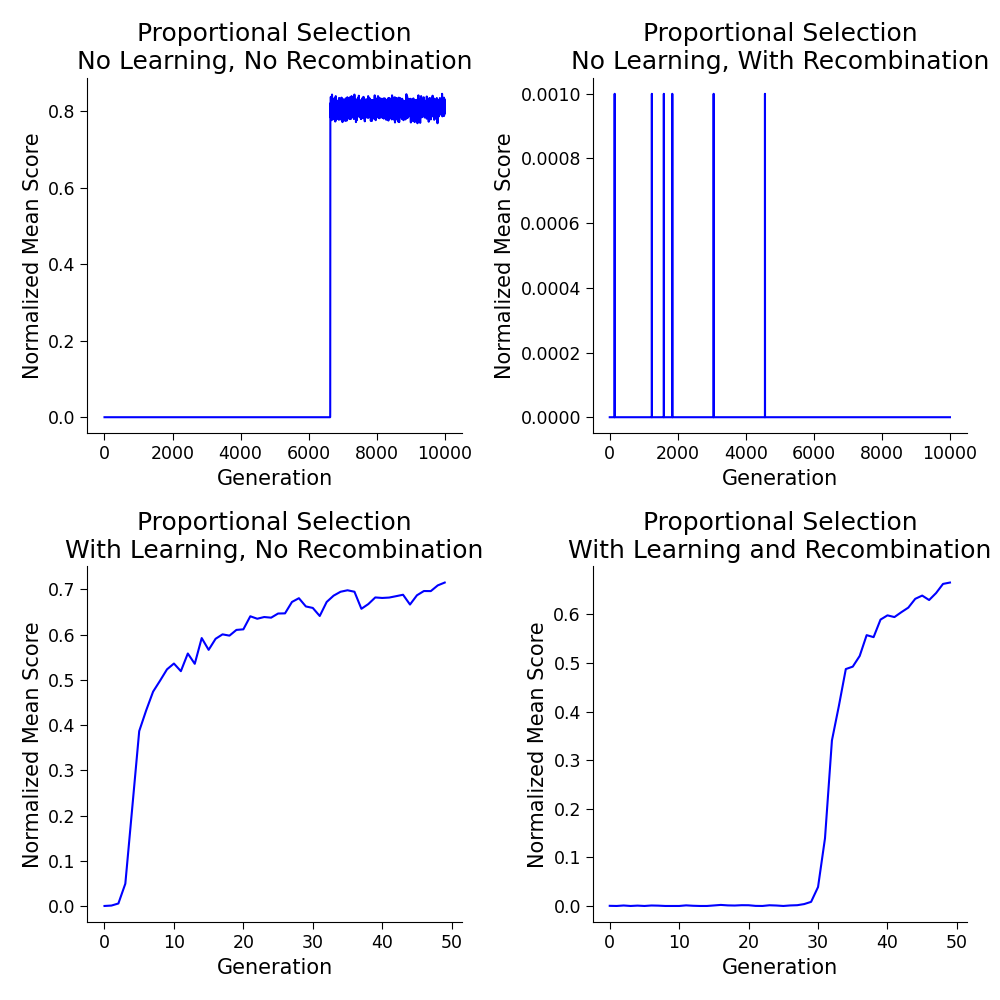

In [8]:
# @markdown **Run this cell** to see how learning and recombination interact when a population is adapting to a 'needle-in-a-haystack' fitness landscape.

common_params = {
    'selection_type': 'proportional',
    'softmax_temp': 1,
    'seed': 234,
    'pop_size': 1000,
    'num_blocks': 1,     # Focus on 1 trait
    'block_size': 20,  # Using 20 bits per block
    'has_mutation': True,
    'mutation_rate': 0.01,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'recombination_type': 'random',
    'proportion_shift': 1.0,
    'proportion_scale': 19.0,
    'has_changing_environment':False,
    'change_env_prop': 0.0,
    'env_change_rate': 0.0,
    'compute_IQR': False,
    'init_pop': 'simple'
}

# Parameters specific to the learning scenario
learning_params = {
    'has_learning': True,
    'n_learning_trials': 1000,
    'n_gen': 50,
}

# Parameters specific to the scenario without learning
no_learning_params = {
    'has_learning': False,
    'n_learning_trials': 1,  # Learning is not occurring
    'n_gen': 10000 #
}

recombination_params = {
    'has_recombination': True,
}

no_recombination_params = {
    'has_recombination': False,
}

# Create 2x1 subplots for comparison
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Function to plot results
def plot_results(ax, simulation_params, title, label):
  results = evo_learning_simulation(**simulation_params)
  generations = np.arange(simulation_params['n_gen'])
  # Calculate normalized mean score
  mean_hist = results['mean_score_hist'] / simulation_params['num_blocks']
  # Plot
  ax.plot(generations, mean_hist, color='blue', label=label)
  ax.set_title(title)
  ax.set_xlabel('Generation')
  ax.set_ylabel('Normalized Mean Score')

# Modify the plot_results function call for each subplot
plot_results(axs[0, 0], {**common_params, **no_learning_params, **no_recombination_params}, "Proportional Selection\nNo Learning, No Recombination", 'No Learn/No Recomb')
plot_results(axs[0, 1], {**common_params, **no_learning_params, **recombination_params}, "Proportional Selection\nNo Learning, With Recombination", 'No Learn/Recomb')
plot_results(axs[1, 0], {**common_params, **learning_params, **no_recombination_params}, "Proportional Selection\nWith Learning, No Recombination", 'Learn/No Recomb')
plot_results(axs[1, 1], {**common_params, **learning_params, **recombination_params}, "Proportional Selection\nWith Learning and Recombination", 'Learn/Recomb')


plt.tight_layout()
# Assuming remove_ip_clutter is a predefined function for cleaning up the plots
remove_ip_clutter(fig)
plt.show()


In the simulation shown in the top right, which features recombination without learning, we observe the emergence of singleton co-adaptations (as indicated by small spikes in the population's mean fitness score). This aligns with our earlier mathematical predictions, yet these co-adaptations fail to spread across the population. Using the approximation from question 4 in the previous section, for a population with 1000 individuals trying to hit upon a 20-bit co-adaptation, the average waiting time until there are two adapted individuals in a single generation is roughly a million generations. If you have time on your hands you could adapt the parameters of the simulation and see how long you have to wait!

In all the other cases the co-adaptation is discovered relatively quickly. Without learning (or recombination, top left), in this one simulation, the co-adaptation is discovered after ~6000 generations of evolutionary grinding. From exercise 2 above, this is roughly aligned with the geometrically distributed waiting time with mean of approximately 5000. (Though several simulations are required to check this alignment more fully.)

In the cases with learning (bottom), the co-adaptation is discovered and spreads within tens, not thousands of generations. This takes slightly longer with recombination (bottom right), but not insurmountably so. Now comparing generational times directly is a bit misleading. In each generation with learning, (in these simulations) each individual could make up to 1000 distinct function evaluations, though given their learning rules they often made far fewer (distinct) evaluations. In stark contrast, in the simulations without learning each individual in each generation made exactly one function evaluation. So from a strict number of function evaluations perspective learning isn't really helping us directly, at least not in the simulations with no recombination.

Our earlier simulations and mathematical models in section 1.3.2 demonstrated that recombination significantly accelerates evolutionary search in simpler fitness landscapes. However, in the context of more complex fitness score functions as explored here, recombination tends to be less advantageous, potentially even a liability, although learning can mitigate this to an extent. It seems as though the ideal situation would be to have a recombination structured in such a way that it both accelerated evolutionary search in some situations, without being an 'adaptive liability' in others. Indeed, this is precisely what we see in the natural world. In recombination, chromosomes are not shattered and shuffled and thrown to the wind all willy nilly, instead, specific break-points where cross-over style recombination events are more likely exist and are situated so as to preserve groups of tightly co-adapted genes. We will not explore this particular idea with simulations, but we can imagine how the genetic mechanisms for setting and maintaining good 'break-points' is itself the result of evolution. Aspects of life history and genetic replication that serve as the foundational assumptions of some evolutionary models, can themselves be understood as the results of evolution by natural selection. They key thing to keep in mind is that evolution is a 'black-box' optimizer, it has and uses no knowledge of the underlying structure of the fitness function, selection acts solely on the output of this function. (Or in some very real sense selection **is** the evaluation of the evaluation of the fitness function.) And so we expect all viable 'adaptive accelerators' to be deployed against 'the vague uncertainties of life'.

We conclude this section on learning and evolution by noting that we used a neural circuit as our motivating sketch of a highly co-adapted trait, and how this relates to lifespan. In an evolutionary context, a longer lifespan not only offers extended periods for learning and adaptation but also allows an organism to maximize the benefits of its investment in learning. This investment isn't trivial—it encompasses both the time devoted to learning and the sophisticated neural architecture required to support it. Our simulations further highlight that complex behaviors, which often involve numerous genetic co-adaptations, are challenging for evolution to both discover and spread within a population. Consequently, we expect, and generally observe, a confluence of extended lifespans, advanced learning capabilities, and complex behaviors in various life forms. This is because each of these traits supports and enhances the others, creating a synergy that is advantageous for survival and reproduction in diverse and changing environments. Brainy, motor-flexible animals, with rich senses exemplify this, and allow us to think about what brains are for in an evolutionary sense: learning adaptive behaviours quickly.

In [9]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")